In [26]:
#%reset
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn as sk
import keras
import tensorflow as tf
from sklearn import metrics
from keras import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, matthews_corrcoef,
                             roc_auc_score, make_scorer)
from sklearn.model_selection import (cross_validate, RandomizedSearchCV,
                                     RepeatedStratifiedKFold)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from eli5.sklearn import PermutationImportance
from matplotlib.patches import Polygon
from scipy.stats import loguniform
from tensorflow import random
from keras.metrics import AUC
from sklearn.feature_selection import SelectFromModel
from Functions_AMR_gonorrhea import effective_unnecessary_threshold, get_best_hyperparameters, get_best_features, get_test_train_data, get_feature_effects, f1_mcc_score_threshold
hfont = {'fontname':'Helvetica'}
import pickle
## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR', 'GENDERSP',
       'Susceptible', 'REGION', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West', 'PREV_REGION',
       'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75',
       'Trend_N_greater_75'],
      dtype='object')


In [27]:
ROC_by_year = [{2005: 0.7304247515090889, 2006: 0.722997895527232, 2007: 0.7066233521880259, 2008: 0.7078638485409549, 2009: 0.6664640534593402, 2010: 0.6856022113843243}, {2005: 0.7549897391764862, 2006: 0.7595409738925509, 2007: 0.7015889650707939, 2008: 0.6966628419433072, 2009: 0.680609279672774, 2010: 0.6846061254892631}, {2005: 0.79921305, 2006: 0.84113616, 2007: 0.7738805, 2008: 0.7741755, 2009: 0.7461454, 2010: 0.7617777}]
best_hyperparameters_by_year = [{2005: {'solver': 'liblinear', 'penalty': 'l2', 'C': 12.91}, 2006: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2007: {'solver': 'liblinear', 'penalty': 'l1', 'C': 8.65}, 2008: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2009: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 97.57000000000001}, 2010: {'solver': 'liblinear', 'penalty': 'l1', 'C': 90.91}}, {2005: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2006: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2007: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2008: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2009: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}, 2010: {'n_estimators': 181, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 99}}, {2005: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2006: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 16, 'kc__batch_size': 5}, 2007: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 16, 'kc__batch_size': 5}, 2008: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.04, 'kc__dense_nparams': 8, 'kc__batch_size': 10}, 2009: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.05, 'kc__dense_nparams': 10, 'kc__batch_size': 15}, 2010: {'kc__optimizer': 'Adamax', 'kc__dropout': 0.04, 'kc__dense_nparams': 8, 'kc__batch_size': 10}}]
best_features_by_year = [{2005: ['West', 'Northeast', 'MSW', 'Southwest', 'MSM', 'MSMW'], 2006: ['West', 'Southwest', 'Southeast', 'MSW', 'MSM', 'Oth/Unk/Missing'], 2007: ['MSW', 'West', 'Oth/Unk/Missing', 'PREV_CLINIC', 'Southwest', 'Trend_N_greater_75', 'Northeast', 'Count_Exceeds_75'], 2008: ['West', 'PREV_CLINIC', 'MSW', 'Count_Exceeds_75', 'Southwest', 'Oth/Unk/Missing'], 2009: ['PREV_CLINIC', 'West', 'MSW', 'DELTA_CLINIC', 'MSM', 'Oth/Unk/Missing', 'Count_Exceeds_75'], 2010: ['PREV_CLINIC', 'DELTA_CLINIC', 'West', 'MSW', 'PREV_REGION', 'Southeast', 'MSM', 'Oth/Unk/Missing', 'DELTA_REGION', 'Northeast', 'Count_Exceeds_75']}, {2005: ['PREV_CLINIC', 'MSM', 'DELTA_CLINIC', 'MSW', 'DELTA_REGION', 'PREV_REGION', 'West', 'MSMW', 'Count_Exceeds_75', 'Southeast', 'Trend_N_greater_75', 'Southwest', 'Oth/Unk/Missing'], 2006: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'DELTA_REGION', 'PREV_REGION', 'MSMW', 'West', 'Trend_N_greater_75', 'Midwest', 'Oth/Unk/Missing', 'Southeast', 'Count_Exceeds_75'], 2007: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Trend_N_greater_75', 'Midwest', 'Northeast', 'Southeast', 'Southwest'], 2008: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'MSMW', 'DELTA_REGION', 'Count_Exceeds_75', 'Midwest', 'West', 'Trend_N_greater_75', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest'], 2009: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'Midwest', 'Southwest', 'West', 'Oth/Unk/Missing', 'Count_Exceeds_75', 'Southeast', 'Northeast', 'Trend_N_greater_75'], 2010: ['PREV_CLINIC', 'MSW', 'MSM', 'DELTA_CLINIC', 'PREV_REGION', 'DELTA_REGION', 'MSMW', 'West', 'Oth/Unk/Missing', 'Midwest', 'Southwest', 'Count_Exceeds_75', 'Northeast', 'Southeast', 'Trend_N_greater_75']}, {2005: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2006: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2007: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2008: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2009: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75'], 2010: ['MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing', 'Northeast', 'Southeast', 'Southwest', 'West', 'Midwest', 'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION', 'DELTA_CLINIC', 'Count_Exceeds_75', 'Trend_N_greater_75']}]

In [28]:

def get_test_train_data(CIP_data_no_drop, year, feature_names, years_train, model_type):
    feature_names_with_weight = feature_names.copy()
    feature_names_with_weight.extend(['weight'])
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin(years_train)]
    X_train = train_data[feature_names_with_weight]  # need to consider all columns BEFORE feature engineering
    y_train = 1 - train_data["Susceptible"]
    # test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop["YEAR"].isin([year])]
    X_test = test_data[feature_names_with_weight]
    y_test = 1 - test_data["Susceptible"]
    cipro_R_prev = y_test.sum() / len(y_test)

    if (model_type == 1) | (model_type == 2):
        X_train, y_train = oversample.fit_resample(X_train, y_train)
        # X_test, y_test = oversample.fit_resample(X_test, y_test)
        print("Oversample")
    weights_train = X_train["weight"]
    X_train  = X_train.drop("weight", axis = 1)
    X_test = X_test.drop("weight", axis = 1)

    return (test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train)

In [18]:
CIP_data_no_drop = CIP_data_no_drop.drop('weight_x', axis = 1)
CIP_data_no_drop = CIP_data_no_drop.drop('weight_y', axis = 1)

In [29]:
# Just LR
model_lr = LogisticRegression(class_weight = 'balanced', max_iter=4000, solver = "lbfgs", C = 0.27, penalty = 'l2')

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.arange(0, 100, .01)
i = 0
test_years = np.array(range(2005, 2011))

for year in test_years: 
    print(year)
    model_type = 0
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
    model_name = "CIP_lr_" + str(year) + ".sav" 
    model_fit = pickle.load(open(model_name, 'rb'))

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type)
    model_fit_train = model_fit.fit(X_train, y_train, sample_weight = weights_train)

    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    print(metrics.roc_auc_score(y_test, y_predict_proba[:,1]))
    ROC_by_year[model_type].__setitem__(year, metrics.roc_auc_score(y_test, y_predict_proba[:,1]))

    #ROC_by_year[model_type].__setitem__(year, ROC)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    print(ROC)
    i += 1

2005
0.7910599970087921
0.7304247515090889
2006
0.767141162514828
0.722997895527232
2007
0.7582075367017401
0.7066233521880259
2008
0.7673286045844524
0.7078638485409549
2009
0.7602982723390607
0.6664640534593402
2010
0.7606162307905812
0.6856022113843243


In [30]:
oversample = RandomOverSampler(sampling_strategy = 'minority',random_state=42) #need for neural network and random forest

i = 0
test_years = np.array(range(2005, 2011))

for year in test_years: 
    print(year)
    model_type = 1
    years_train = np.array(range(year - 5, year))

    CIP_data_training_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    CIP_data_testing_years = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    # first do for all clinics 

    counts = CIP_data_training_years.groupby(['YEAR', 'CLINIC']).size().reset_index(name='Count')
    counts_by_year = CIP_data_training_years.groupby(['YEAR']).size().reset_index(name='Count')

    merged_counts = counts.merge(counts_by_year, on='YEAR', suffixes=('_counts', '_counts_by_year'))

    # Calculate the sum of all counts in the counts dataframe
    total_counts = counts['Count'].sum()

    # Calculate the 'weight' column as Count_counts / total_counts
    merged_counts['weight'] = merged_counts['Count_counts'] / total_counts
    # Calculate the 'weight' column as Count_counts / rolling sum of the previous 5 years

    # Merge the 'weight' column back to the original DataFrame
    CIP_data_no_drop = CIP_data_no_drop.merge(merged_counts[['YEAR', 'CLINIC', 'weight']], on=['YEAR', 'CLINIC'], how='left')
    model_name = "CIP_rf_" + str(year) + ".sav" 
    model_fit = pickle.load(open(model_name, 'rb'))

    test_data, train_data, X_train, y_train, X_test, y_test, cipro_R_prev, weights_train =  get_test_train_data(CIP_data_no_drop = CIP_data_no_drop, year = year, feature_names = best_features_by_year[model_type][year], years_train = years_train, model_type = model_type)
    model_fit_train = model_fit.fit(X_train, y_train, sample_weight = weights_train)

    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    ROC= metrics.roc_auc_score(y_test, y_predict_test)
    ROC_by_year[model_type].__setitem__(year, metrics.roc_auc_score(y_test, y_predict_proba[:,1]))

    print(metrics.roc_auc_score(y_test, y_predict_proba[:,1]))
    #ROC_by_year[model_type].__setitem__(year, ROC)
    CIP_data_no_drop = CIP_data_no_drop.drop('weight', axis = 1)
    print(ROC)
    i += 1

2005
Oversample
0.8250799289955916
0.7587285957014871
2006
Oversample
0.8279589554306367
0.7582805518897848
2007
Oversample
0.7658726556082294
0.694512205551674
2008
Oversample
0.7773858450465486
0.702337079823715
2009
Oversample
0.7454250204461756
0.6900621585561381
2010
Oversample
0.7519287304365557
0.6872430483570389


In [31]:
ROC_by_year

[{2005: 0.7910599970087921,
  2006: 0.767141162514828,
  2007: 0.7582075367017401,
  2008: 0.7673286045844524,
  2009: 0.7602982723390607,
  2010: 0.7606162307905812},
 {2005: 0.8250799289955916,
  2006: 0.8279589554306367,
  2007: 0.7658726556082294,
  2008: 0.7773858450465486,
  2009: 0.7454250204461756,
  2010: 0.7519287304365557},
 {2005: 0.79921305,
  2006: 0.84113616,
  2007: 0.7738805,
  2008: 0.7741755,
  2009: 0.7461454,
  2010: 0.7617777}]

In [20]:
ROC_by_year = [{2005: 0.7304247515090889, 2006: 0.722997895527232, 2007: 0.7066233521880259, 2008: 0.7078638485409549, 2009: 0.6664640534593402, 2010: 0.6856022113843243}, {2005: 0.7549897391764862, 2006: 0.7595409738925509, 2007: 0.7015889650707939, 2008: 0.6966628419433072, 2009: 0.680609279672774, 2010: 0.6846061254892631}, {2005: 0.79921305, 2006: 0.84113616, 2007: 0.7738805, 2008: 0.7741755, 2009: 0.7461454, 2010: 0.7617777}]


In [32]:
ROC_by_year = [{2005: 0.7910599970087921,
  2006: 0.767141162514828,
  2007: 0.7582075367017401,
  2008: 0.7673286045844524,
  2009: 0.7602982723390607,
  2010: 0.7606162307905812},
 {2005: 0.8250799289955916,
  2006: 0.8279589554306367,
  2007: 0.7658726556082294,
  2008: 0.7773858450465486,
  2009: 0.7454250204461756,
  2010: 0.7519287304365557},
 {2005: 0.79921305,
  2006: 0.84113616,
  2007: 0.7738805,
  2008: 0.7741755,
  2009: 0.7461454,
  2010: 0.7617777}]

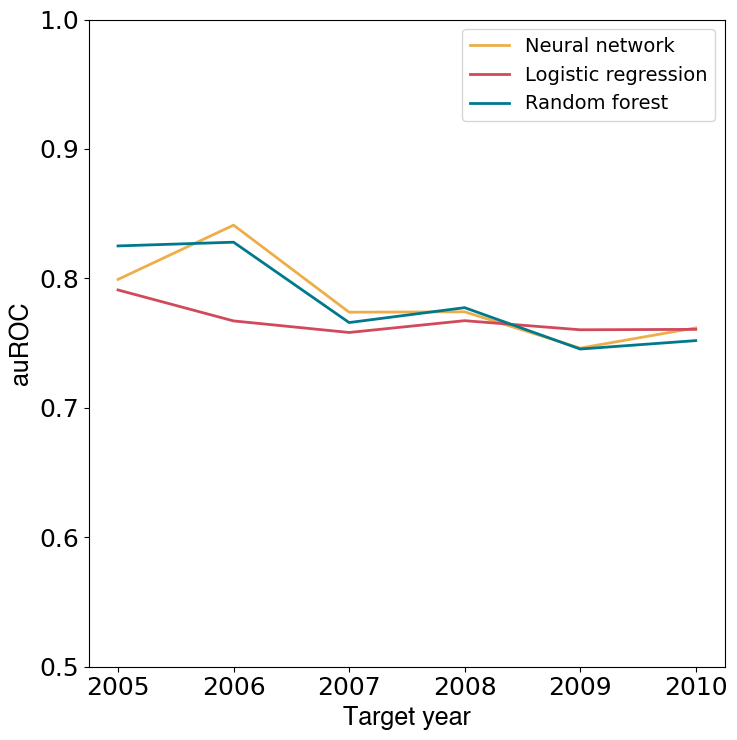

In [23]:
############# Graph 1: auROC by year 2005-2010, trained on previous 5 years' data, for nn, rf and lr with intervals
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
years = np.array(range(2005, 2011))
axs.tick_params(axis='both', which='major', labelsize=18)
axs.set_xticks(np.array(range(2005, 2011)))
#axs.set_xticks([2005, 2007, 2010])

axs.plot(years, ROC_by_year[2].values(),linewidth = 2, label = "Neural network", color = "#edae49")

axs.plot(years, ROC_by_year[0].values(),linewidth = 2, label = "Logistic regression", color = "#d1495b")

axs.plot(years, ROC_by_year[1].values(),linewidth = 2, label = "Random forest", color = "#00798c")

axs.set_ylabel("auROC", fontsize = 18, **hfont)
axs.set_xlabel("Target year",  fontsize = 18,**hfont)
axs.set_ylim([0.5,1])
axs.legend(prop={'size':14})
plt.tight_layout()

In [25]:
ROC_by_year = [{2005: 0.7910599970087921,
  2006: 0.767141162514828,
  2007: 0.7582075367017401,
  2008: 0.7673286045844524,
  2009: 0.7602982723390607,
  2010: 0.7606162307905812},
 {2005: 0.8250799289955916,
  2006: 0.8279589554306367,
  2007: 0.7658726556082294,
  2008: 0.7773858450465486,
  2009: 0.7454250204461756,
  2010: 0.7519287304365557},
 {2005: 0.79921305,
  2006: 0.84113616,
  2007: 0.7738805,
  2008: 0.7741755,
  2009: 0.7461454,
  2010: 0.7617777}]